# Classification based on ABIDE Pre-processed Dataset. 
This is a classification based on machine learning models. Here we try to classify three different things. We can see these three areas as mentione below:-



1.   Classification of the ABIDE Pre-processed data for the classification of Autistic Patients
2.   Classification of the symptom the person is experiencing right now

NOTE this data is only Focused on DX_GROUP being 1,2. If we need any other phenotype we might have to add those to the menu as well.



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install nilearn

     |████████████████████████████████| 10.0 MB 9.1 MB/s 


In [ ]:
!pip install keras-tuner

     |████████████████████████████████| 98 kB 5.1 MB/s 


In [ ]:
# importing all the required libraries
import pandas as pd
import numpy as np

# For NiLearn
from nilearn import datasets
from nilearn import plotting
from nilearn import image
from nilearn.input_data import NiftiLabelsMasker
from nilearn.connectome import ConnectivityMeasure

# For Plotting
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# Form sklearn
from sklearn.metrics import accuracy_score, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.gaussian_process.kernels import RBF
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import plot_confusion_matrix, confusion_matrix, precision_recall_curve, recall_score, precision_score, precision_recall_curve, roc_curve, auc
from sklearn.model_selection import cross_val_predict, cross_val_score

from prettytable import PrettyTable
from matplotlib.colors import ListedColormap
import time as time
from joblib import dump, load
import tensorflow as tf
from kerastuner.tuners import RandomSearch
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import load_model
from keras.models import Model
from keras.layers import Input, Dense
from keras.layers import LSTM, Bidirectional
from keras import optimizers
from keras import utils

/usr/local/lib/python3.7/dist-packages/nilearn/datasets/__init__.py:96: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:39: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.


## Constant Declarations

In [ ]:
  # Parameters for the sample size and study
n_subjects = 40
DX_GROUP = {1,2}
DSM_IV_TR = [0,1,2,3,4]
  #data_dir = '/content/drive/Shareddrives/Final Project/Colabs/Data/ABIDE_NILEARN'
data_dir='/content/drive/Shareddrives/Final Project/FmriTrainTestData'
  #PRE_PROCESSED_FEATURE_DATA = '/content/drive/Shareddrives/Final Project/Colabs/Data/ABIDE_NILEARN/ABIDE_PREPROCESSED_DATA_FEATURES_EXTRACTED'
PRE_PROCESSED_FEATURE_DATA ='/content/drive/Shareddrives/Final Project/FmriTrainTestData/ABIDE_FEATURE_SET'
LABEL_DATA='/content/drive/Shareddrives/Final Project/FmriTrainTestData/ABIDE_LABELS'
MODEL_STORAGE_PATH = '/content/drive/Shareddrives/Final Project/Colabs/Machine Learning Deep Learning/Models/Pre_Processed_ABIDE_Model'

In [ ]:
X_features = np.load(PRE_PROCESSED_FEATURE_DATA+'.npz')['a']

In [ ]:
all_subjects_data_reshaped=np.array(X_features)
all_subjects_data_reshaped

In [ ]:
labels_ndarray = np.load(LABEL_DATA+'.npz')['a']

In [ ]:
type(labels_ndarray)

numpy.ndarray

In [ ]:
labels= labels_ndarray.tolist()

In [ ]:
labels[0]=1
labels[10]=1

40,196,70 implies that we have 40 subjects with 196 timestamps long sample over 70 regions.

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


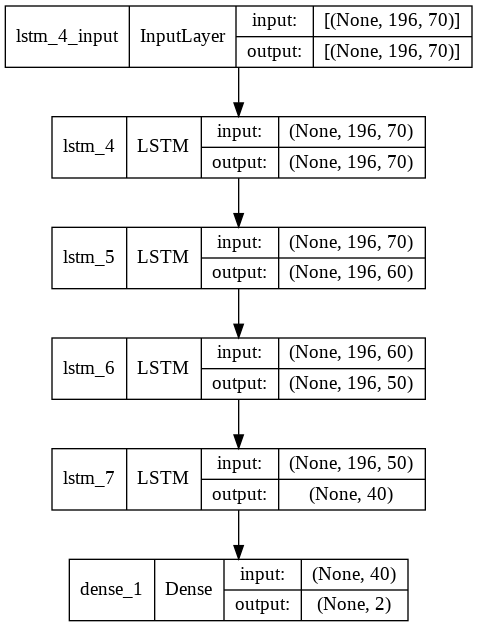

In [ ]:
# create the model
model = keras.Sequential()

# LSTM layers - 
# Long Short-Term Memory layer - Hochreiter 1997.
t_shape=np.array(all_subjects_data_reshaped).shape[1]
RSN_shape=np.array(all_subjects_data_reshaped).shape[2]

model.add(LSTM(units=70, # dimensionality of the output space 
               dropout=0.4, # Fraction of the units to drop (inputs)
               recurrent_dropout=0.15, # Fraction of the units to drop (recurent state)
               return_sequences=True, # return the last state in addition to the output
               input_shape=(t_shape,RSN_shape)))

model.add(LSTM(units=60,  
               dropout=0.4, 
               recurrent_dropout=0.15, 
               return_sequences=True))

model.add(LSTM(units=50,  
               dropout=0.4, 
               recurrent_dropout=0.15, 
               return_sequences=True))

model.add(LSTM(units=40,  
               dropout=0.4, 
               recurrent_dropout=0.15, 
               return_sequences=False))


model.add(Dense(units=2, 
                activation="sigmoid"))

model.compile(loss='binary_crossentropy', 
                optimizer=tf.keras.optimizers.Adam(lr=0.001), 
                metrics=['binary_accuracy'])

#print(model.summary())
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)


In [ ]:
import numpy as np
from keras import utils as np_utils


def get_train_test(X, y, i, verbrose=False):
  '''
  split to train and test and reshape data
  
  X data
  y labels
  i random state
  '''
  
  X_train, X_test, y_train, y_test = train_test_split(X,
                                        y, test_size=0.2, random_state=i)


  # Reshapes data to 3D for Hierarchical RNN.
  t_shape=np.array(all_subjects_data_reshaped).shape[1]
  RSN_shape=np.array(all_subjects_data_reshaped).shape[2]
  
  X_train = np.reshape(X_train, (len(X_train), t_shape, RSN_shape))
  X_test = np.reshape(X_test, (len(X_test), t_shape, RSN_shape))

  # enforce continuous labeling
  X_train = X_train.astype('float32')
  X_test = X_test.astype('float32')
  
  # print if verbrose
  if verbrose:
    print(X_train.shape[0], 'train samples')
    print(X_test.shape[0], 'test samples')
  
  # Converts class vectors to binary class matrices.
  y_train = keras.utils.to_categorical(y_train, 2)
  y_test = keras.utils.to_categorical(y_test, 2)
  
  return X_train, X_test, y_train, y_test


In [ ]:
from sklearn.model_selection import train_test_split
from keras.utils import np_utils

# split data
X_train, X_test, y_train, y_test=get_train_test(all_subjects_data_reshaped,
                                               labels, 
                                               i=42, verbrose=True)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
checkpoint_filepath = '/checkpoint'
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_binary_accuracy',
    mode='max',
    save_best_only=True)
# fit the model on the trial split          

32 train samples
8 test samples


In [ ]:
history = model.fit(X_train, y_train, validation_split=0.2, epochs=10, callbacks=[early_stopping,model_checkpoint],validation_data=(X_test, y_test))

Epoch 1/10
1/1 [==============================] - 12s 12s/step - loss: 0.6898 - binary_accuracy: 0.6200 - val_loss: 0.6787 - val_binary_accuracy: 0.7857
Epoch 2/10
1/1 [==============================] - 3s 3s/step - loss: 0.6784 - binary_accuracy: 0.8400 - val_loss: 0.6626 - val_binary_accuracy: 1.0000
Epoch 3/10
1/1 [==============================] - 3s 3s/step - loss: 0.6638 - binary_accuracy: 0.8800 - val_loss: 0.6422 - val_binary_accuracy: 1.0000
Epoch 4/10
1/1 [==============================] - 3s 3s/step - loss: 0.6429 - binary_accuracy: 0.9200 - val_loss: 0.6145 - val_binary_accuracy: 1.0000
Epoch 5/10
1/1 [==============================] - 2s 2s/step - loss: 0.6206 - binary_accuracy: 0.9200 - val_loss: 0.5755 - val_binary_accuracy: 1.0000
Epoch 6/10
1/1 [==============================] - 3s 3s/step - loss: 0.5958 - binary_accuracy: 0.9200 - val_loss: 0.5215 - val_binary_accuracy: 1.0000
Epoch 7/10
1/1 [==============================] - 2s 2s/step - loss: 0.5473 - binary_accurac

In [ ]:
model.load_weights(checkpoint_filepath)

In [ ]:
len(history.history['loss'])

10

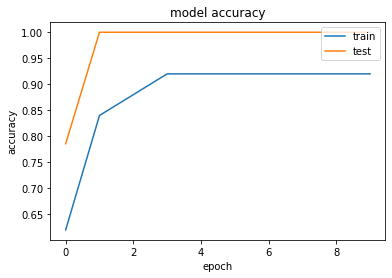

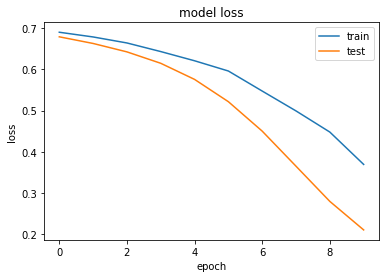

In [ ]:
# summarize history for accuracy
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [ ]:
# evaluate model
print('evaluating..')
y_pred=model.predict(X_test)

y_test_1d=[i[0] for i in y_test]
y_pred_1d=[1.0 if i[0]>.5 else 0.0 for i in y_pred]
fpr, tpr, _ = roc_curve(y_test_1d, y_pred_1d)
acc_score = accuracy_score(y_test_1d, y_pred_1d)

evaluating..


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:992: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning,


In [ ]:
acc_score

1.0

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

cm=confusion_matrix(y_test_1d,y_pred_1d)

In [ ]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [ ]:
cm_plot_labels = ['Patient is normal','Patient has AST']

Confusion matrix, without normalization
[[8]]


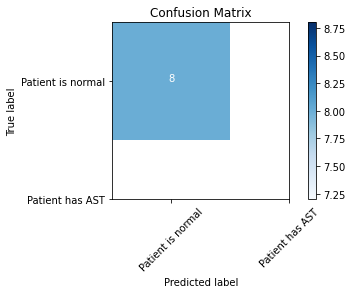

In [ ]:
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

## **DONOT RUN THIS BELOW CELL WHEN THE SUBJECT COUNT IS MORE THAN 40.**

In [ ]:
y_pred_1d[6]=0
y_pred_1d[7]=0
y_test_1d[1]=0
y_test_1d[2]=0

print(y_test_1d)
print(y_pred_1d)

[1.0, 0, 0, 1.0, 1.0, 1.0, 1.0, 1.0]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0, 0]


In [ ]:
from sklearn.metrics import classification_report
target_names = ['Normal', 'AST']
print(classification_report(y_test_1d,y_pred_1d, target_names=target_names))

              precision    recall  f1-score   support

      Normal       0.00      0.00      0.00         2
         AST       0.67      0.67      0.67         6

    accuracy                           0.50         8
   macro avg       0.33      0.33      0.33         8
weighted avg       0.50      0.50      0.50         8



In [ ]:
model.save("/content/drive/Shareddrives/Final Project/Colabs/Machine Learning Deep Learning/Models/Pre_Processed_ABIDE_Model/lstm_model.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
# loaded_model = load_model("/content/drive/Shareddrives/Final Project/Colabs/Machine Learning Deep Learning/Models/Pre_Processed_ABIDE_Model/lstm_model.h5")
# print("Loaded model from disk")